In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC 
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

from xgboost import XGBClassifier

from imblearn.combine import SMOTETomek # because our data is unbalanced

random_state = 42
np.random.seed(random_state)

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive


In [4]:
dat_nurse = pd.read_csv('prepared_1061.csv')
dat_nurse

,HADM_ID,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,...,ROW_ID,SUBJECT_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,100213,1,100213,0.0,74,2,26.814570,1,0,0,...,1170971,85723,2154-02-13,2154-02-13 00:49:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2154-2-13**] 12:49 AM\n CHEST (PORTABLE AP)...
1,100449,2,100449,0.0,87,1,24.000000,1,0,0,...,1203496,77177,2137-08-16,2137-08-16 08:11:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2137-8-16**] 8:11 AM\n CHEST (PORTABLE AP) ...
2,100571,1,100571,0.0,67,1,32.284350,1,0,0,...,1058554,99008,2173-02-19,2173-02-19 19:18:00,2173-02-20 06:44:48,Radiology,CHEST (PORTABLE AP),18928.0,NaN,[**2173-2-19**] 7:18 PM\n CHEST (PORTABLE AP) ...
3,100610,1,100610,0.0,81,2,NaN,1,1,0,...,1221573,68674,2136-12-19,2136-12-19 16:32:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2136-12-19**] 4:32 PM\n CHEST (PORTABLE AP)...
4,100660,1,100660,0.0,75,1,NaN,1,0,0,...,948144,631,2124-01-23,2124-01-23 13:11:00,2124-01-23 14:07:00,Radiology,CHEST (PORTABLE AP),15597.0,NaN,[**2124-1-23**] 1:11 PM\n CHEST (PORTABLE AP) ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,199786,2,199786,1.0,43,2,19.682579,0,0,0,...,1126455,88098,2119-02-17,2119-02-17 14:21:00,NaN,Radiology,TUNNELED W/O PORT,NaN,NaN,"[**Last Name (LF) 26254**],[**First Name3 (LF)..."
1057,199803,2,199803,0.0,81,2,33.669422,1,1,0,...,1222534,50484,2160-02-07,2160-02-07 15:11:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2160-2-7**] 3:11 PM\n CHEST (PORTABLE AP) ...
1058,199859,2,199859,0.0,55,2,NaN,0,1,0,...,1221894,99650,2156-12-25,2156-12-25 05:28:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2156-12-25**] 5:28 AM\n CHEST (PORTABLE AP)...
1059,199912,2,199912,1.0,89,2,25.080360,1,0,0,...,979089,29256,2198-09-19,2198-09-19 00:10:00,2198-09-19 06:23:00,Radiology,CT HEAD W/O CONTRAST,15023.0,NaN,[**2198-9-19**] 12:10 AM\n CT HEAD W/O CONTRAS...


In [5]:
# drop na (outcome na)
dat_nurse = dat_nurse[dat_nurse['outcome'].notnull()]
# train-test-split
train_dat, test_dat = train_test_split(dat_nurse, test_size = 0.15,  stratify=dat_nurse['outcome'], random_state=random_state)
# val_dat, test_dat = train_test_split(test_dat, test_size = 0.5, stratify=test_dat['outcome'], random_state=random_state)

In [6]:
# organizing data
clin_col = train_dat.columns[4:-10] # remove IDs, outcome, text
outcome_col = train_dat.columns[3]
text_col = train_dat.columns[-8:]

train_dat_clin, test_dat_clin = train_dat.loc[:, clin_col], test_dat.loc[:, clin_col]
train_dat_outcome, test_dat_outcome = train_dat.loc[:, outcome_col], test_dat.loc[:, outcome_col]
train_dat_text, test_dat_text = train_dat.loc[:, text_col], test_dat.loc[:, text_col]

In [7]:
# standardize & impute clinical
clin_pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('med_imputer', SimpleImputer(strategy = "median"))
])

clin_pipe.fit(train_dat_clin)
train_dat_clin_imp = clin_pipe.transform(train_dat_clin)
# val_dat_clin_imp = clin_pipe.transform(val_dat_clin)
test_dat_clin_imp = clin_pipe.transform(test_dat_clin)

In [8]:
train_dat_clin_imp.shape

(901, 48)

In [9]:
test_dat_clin_imp.shape

(159, 48)

In [10]:
X_train = pd.DataFrame(train_dat_clin_imp, columns=clin_col)
y_train = train_dat_outcome
X_test = pd.DataFrame(test_dat_clin_imp, columns=clin_col)
y_test = test_dat_outcome

In [11]:
X_train

,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,-0.335780,-1.016789,-0.191100,0.638602,1.119151,-0.292476,-0.875595,-0.724248,-0.369042,-0.742142,...,0.612577,-0.597422,0.871298,0.647046,1.001443,1.235482,-0.758336,-0.469706,-1.082012,0.113810
1,0.555567,0.983488,-0.201439,0.638602,1.119151,-0.292476,-0.875595,1.380743,-0.369042,1.347451,...,0.119196,0.340488,0.420275,-0.149546,0.604720,-0.388414,-0.320786,0.182031,-0.520786,0.498440
2,-1.004290,-1.016789,0.023946,0.638602,1.119151,-0.292476,-0.875595,-0.724248,2.709722,1.347451,...,0.624393,-0.484525,0.796894,1.970974,1.216686,0.090908,-1.424023,-0.772299,-0.825113,-1.040082
3,0.184172,-1.016789,0.484486,0.638602,-0.893534,-0.292476,-0.875595,-0.724248,-0.369042,-0.742142,...,1.095098,-0.006886,-0.041615,-2.308389,1.585355,0.094661,2.062469,-0.974027,1.642439,0.498440
4,0.555567,-1.016789,0.114950,0.638602,-0.893534,-0.292476,-0.875595,1.380743,-0.369042,-0.742142,...,0.562308,0.548913,0.734361,0.763811,0.900152,0.585014,-0.708065,-1.074891,-1.082012,2.036963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,0.035614,-1.016789,-0.318861,0.638602,-0.893534,-0.292476,1.142080,1.380743,-0.369042,-0.742142,...,-0.461069,-1.092430,0.163669,-0.149546,-0.619210,0.785158,-0.512297,-0.086423,-1.129440,0.113810
897,-1.301406,0.983488,1.073556,0.638602,-0.893534,-0.292476,1.142080,-0.724248,-0.369042,1.347451,...,1.294800,2.285783,0.090353,1.012908,-0.221282,-0.040436,0.402702,0.707042,0.340815,-0.655452
898,-0.112944,0.983488,-0.614700,0.638602,-0.893534,-0.292476,-0.875595,-0.724248,-0.369042,-0.742142,...,1.132024,1.035237,-1.963080,-1.478064,-0.492597,0.034618,3.773306,-0.721867,2.685846,0.498440
899,0.852682,-1.016789,0.251995,-1.565921,1.119151,-0.292476,-0.875595,-0.724248,-0.369042,1.347451,...,-0.144561,0.216426,-0.924339,-0.647740,1.026765,0.034618,1.275144,-0.368842,0.577953,0.113810


In [12]:
smote_tomek = SMOTETomek(random_state = random_state)
X_train, y_train = smote_tomek.fit_resample(X_train, y_train)

In [12]:
params = {
    'LogisticRegressionCV' : {
        'penalty': ['l2'],
        'Cs': [np.logspace(-4, 4, 20)],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
    'SVC' : {
        'kernel' : ['linear', 'poly', 'rbf'],
        'degree' : [3, 4, 5],
        'C': np.logspace(-4, 4, 20)

    },
    'GaussianProcessClassifier' : { # https://stackoverflow.com/questions/62755556/gaussian-process-regression-hyparameter-optimisation-using-python-grid-search
           "kernel": [RBF(l) for l in np.logspace(-1, 1, 10)] + \
           [Matern(length_scale=l) for l in np.logspace(-1, 1, 10)] + \
           [RationalQuadratic(alpha=a, length_scale=l) for a in np.logspace(-1, 1, 5) for l in np.logspace(-1, 1, 5)] + \
           [WhiteKernel(noise_level=n) for n in np.logspace(-2, 2, 10)]
        },
    'XGBClassifier' : { # got from some towardsdatascience article i forgot
            'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
            'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
            'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
            'n_estimators': [50, 65, 80, 100, 115, 130, 150],
            'reg_alpha': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
            'reg_lambda': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
            'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'eval_metric': ['auc'],
            'objective': ['binary:logistic']
    },
    'RandomForestClassifier': {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    }
}

In [13]:
def fit(x, y, parameters, n_iter, random_state = 42):
    """
    Randomized hyperparameter tuning for fitting models

    parameters:
        n_iter -- number of parameter settings sampled
    """
    print("Training LogisticRegressionCV:")
    lr = LogisticRegressionCV(max_iter = int(1e6))
    rs_lr = RandomizedSearchCV(lr, parameters['LogisticRegressionCV'], n_iter = n_iter, random_state=random_state)
    rs_lr.fit(x, y) 

    print("Training SVC:")
    svc = SVC(probability = True)
    rs_svc = RandomizedSearchCV(svc, parameters['SVC'], n_iter = n_iter, random_state=random_state)
    rs_svc.fit(x, y)

    print("Training GaussianProcessClassifier:")
    gp = GaussianProcessClassifier()
    rs_gp = RandomizedSearchCV(gp, parameters['GaussianProcessClassifier'], n_iter = n_iter, random_state=random_state)
    rs_gp.fit(x, y)

    print("Training XGBClassifier:")
    xgb = XGBClassifier()
    rs_xgb = RandomizedSearchCV(xgb, parameters['XGBClassifier'], n_iter = n_iter, random_state=random_state)
    rs_xgb.fit(x, y) 

    print("Training RandomForestClassifier:")
    rf = RandomForestClassifier(random_state=random_state)
    rs_rf = RandomizedSearchCV(rf, parameters['RandomForestClassifier'], n_iter=n_iter, random_state=random_state)
    rs_rf.fit(x, y)

    models = [rs_lr, rs_svc, rs_gp, rs_xgb, rs_rf]
    return models 

In [14]:
models = fit(X_train, y_train, params, n_iter = 20, random_state = random_state)

Training LogisticRegressionCV:


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training SVC:
Training GaussianProcessClassifier:


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal

Training XGBClassifier:
Training RandomForestClassifier:


In [15]:
for model in models:
    print(model.best_estimator_, model.best_params_, model.best_score_)

LogisticRegressionCV(Cs=array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                     max_iter=1000000, solver='liblinear') {'solver': 'liblinear', 'penalty': 'l2', 'Cs': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])} 0.8173928084491566
SVC(C=11.288378916846883, degree=4, probability=True) {'kernel': 'rbf', 'degree': 4, 'C': 11.288378916846883} 0.9725585559919414
Gaussian

In [16]:
def evaluate(x, y, models):
    scores = {
        'ACC': [], 
        'AUC': [],
        'CMAT': []
    }
    for model in models:
        y_pred = model.predict(x)
        y_proba = model.predict_proba(x)[:, 1]
        scores['ACC'].append(accuracy_score(y, y_pred))
        scores['AUC'].append(roc_auc_score(y, y_proba))
        scores['CMAT'].append(confusion_matrix(y, y_pred))
        
    return scores 

In [17]:
evaluate(X_test, y_test, models)

{'ACC': [0.7358490566037735,
  0.8490566037735849,
  0.7924528301886793,
  0.8490566037735849,
  0.8867924528301887],
 'AUC': [0.7270531400966184,
  0.5821256038647343,
  0.7443064182194616,
  0.7922705314009663,
  0.7717391304347826],
 'CMAT': [array([[105,  33],
         [  9,  12]]),
  array([[131,   7],
         [ 17,   4]]),
  array([[116,  22],
         [ 11,  10]]),
  array([[128,  10],
         [ 14,   7]]),
  array([[134,   4],
         [ 14,   7]])]}

## Kept Best Model for run next time directly

In [25]:
# Kept Best Model for run next time
best_params = {
    'LogisticRegressionCV': {
        'penalty': ['l2'],
        'Cs': [np.array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
                        4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
                        2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
                        1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
                        5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])],
        'solver': ['liblinear']
    },
    'SVC': {
        'kernel': ['rbf'],
        'degree': [4],
        'probability':[True],
        'C': [11.288378916846883]
    },
    'GaussianProcessClassifier': {
        'kernel': [Matern(length_scale=0.464, nu=1.5)]
    },
    'XGBClassifier': {
        'subsample': [0.7],
        'reg_lambda': [12.8],
        'reg_alpha': [3.2],
        'objective': ['binary:logistic'],
        'n_estimators': [115],
        'max_depth': [9],
        'learning_rate': [0.1],
        'gamma': [0],
        'eval_metric': ['auc'],
        'colsample_bytree': [0.5],
        'colsample_bylevel': [0.7]
    },
    'RandomForestClassifier': {
        'n_estimators': [100],
        'min_samples_split': [2],
        'min_samples_leaf': [2],
        'max_depth': [30],
        'class_weight': ['balanced'],
        'bootstrap': [False]
    }
}


In [26]:
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score


def best_fit(X_train, y_train, params, n_iter=20, random_state=None):
    models = {
        'LogisticRegressionCV': LogisticRegressionCV,
        'SVC': SVC,
        'GaussianProcessClassifier': GaussianProcessClassifier,
        'XGBClassifier': XGBClassifier,
        'RandomForestClassifier': RandomForestClassifier
    }
    
    fitted_models = {}
    
    for model_name, model_class in models.items():
        clf = model_class()
        search = RandomizedSearchCV(
            estimator=clf,
            param_distributions=params[model_name],
            n_iter=n_iter,
            random_state=random_state,
            n_jobs=-1,
            verbose=1
        )
        search.fit(X_train, y_train)
        print(f"Best {model_name} parameters: {search.best_params_}")
        print(f"Best {model_name} accuracy: {search.best_score_:.5f}")
        fitted_models[model_name] = search.best_estimator_
    
    return fitted_models


# Usage:
random_state = 42
models = best_fit(X_train, y_train, best_params, n_iter=20, random_state=random_state)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best LogisticRegressionCV parameters: {'solver': 'liblinear', 'penalty': 'l2', 'Cs': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}
Best LogisticRegressionCV accuracy: 0.81739
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best SVC parameters: {'probability': True, 'kernel': 'rbf', 'degree': 4, 'C': 11.288378916846883}
Best SVC accuracy: 0.97256
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best GaussianProcessClassifier parameters: {'kernel': Matern(length_scale=0.464, nu=1.5)}
Best GaussianProcessClassifier accuracy: 0.89849
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best XGBClassifier parameters: {'subsample': 0.7, 'reg_lambda': 12.8, 'reg_alpha': 3.2, 'objective': 'binary:logistic', 'n_estimators': 115, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'eval_metric': 'auc', 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7}
Best XGBClassifier accuracy: 0.94195
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best RandomForestClassifier parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30, 'class_weight': 'balanced', 'bootstrap': False}
Best RandomForestClassifier accuracy: 0.96490


In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

def evaluate(X, y, models):
    scores = {
        'ACC': [],
        'AUC': [],
        'CMAT': []
    }
    
    for model_name, model in models.items():
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)[:, 1]
        acc = accuracy_score(y, y_pred)
        auc = roc_auc_score(y, y_proba)
        cmat = confusion_matrix(y, y_pred)

        scores['ACC'].append(acc)
        scores['AUC'].append(auc)
        scores['CMAT'].append(cmat)

        print(f"{model_name} Accuracy: {acc:.5f}")
        print(f"{model_name} AUC: {auc:.5f}")
        print(f"{model_name} Confusion Matrix:\n{cmat}\n")
        
    return scores

In [28]:
evaluation_results = evaluate(X_test, y_test, models)

LogisticRegressionCV Accuracy: 0.73585
LogisticRegressionCV AUC: 0.72705
LogisticRegressionCV Confusion Matrix:
[[105  33]
 [  9  12]]

SVC Accuracy: 0.84906
SVC AUC: 0.58213
SVC Confusion Matrix:
[[131   7]
 [ 17   4]]

GaussianProcessClassifier Accuracy: 0.79245
GaussianProcessClassifier AUC: 0.74431
GaussianProcessClassifier Confusion Matrix:
[[116  22]
 [ 11  10]]

XGBClassifier Accuracy: 0.84906
XGBClassifier AUC: 0.79227
XGBClassifier Confusion Matrix:
[[128  10]
 [ 14   7]]

RandomForestClassifier Accuracy: 0.86164
RandomForestClassifier AUC: 0.74362
RandomForestClassifier Confusion Matrix:
[[132   6]
 [ 16   5]]



###Visualization of Model Performance

1. Logistic Regression CV

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cmat, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cmat, annot=True, cmap="YlGnBu", fmt='d')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [19]:
def plot_coefficients(lr_model, feature_names):
    coef = lr_model.coef_.ravel()
    plt.figure(figsize=(10, 5))
    plt.bar(feature_names, coef)
    plt.xticks(rotation=90)
    plt.title('Logistic Regression Coefficients')
    plt.xlabel('Features')
    plt.ylabel('Coefficients')
    plt.show()


In [20]:
def plot_odds_log_odds(lr_model, feature_names):
    coef = lr_model.coef_.ravel()
    odds = np.exp(coef)
    log_odds = coef

    plt.figure(figsize=(10, 5))
    plt.bar(feature_names, odds, label='Odds')
    plt.bar(feature_names, log_odds, label='Log Odds')
    plt.xticks(rotation=90)
    plt.title('Odds and Log Odds')
    plt.xlabel('Features')
    plt.legend()
    plt.show()


In [21]:
def plot_correlation_matrix(x):
    corr = x.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr,  cmap="coolwarm", fmt='.2f', square=True)
    plt.title('Correlation Matrix')
    plt.show()


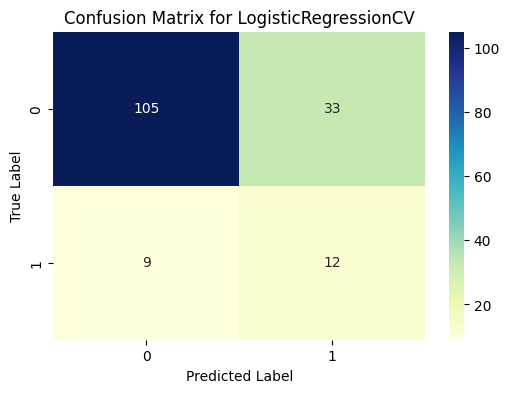

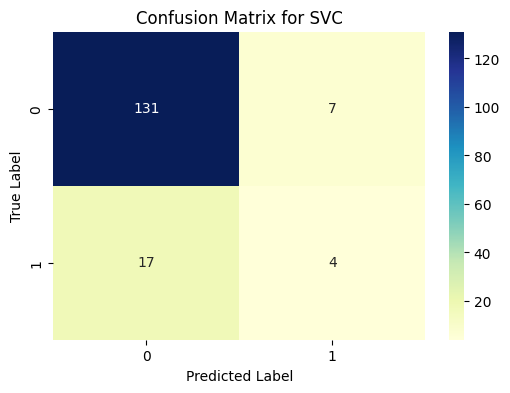

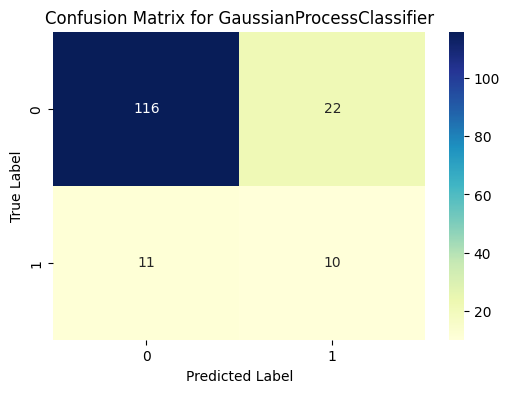

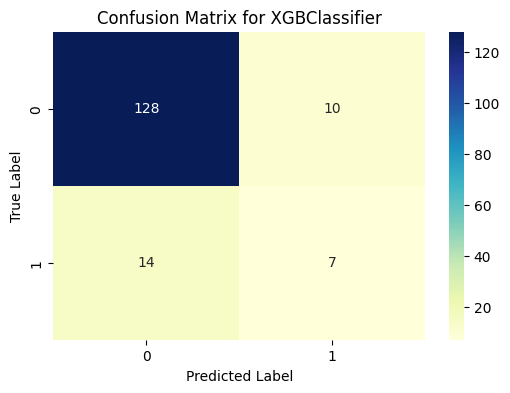

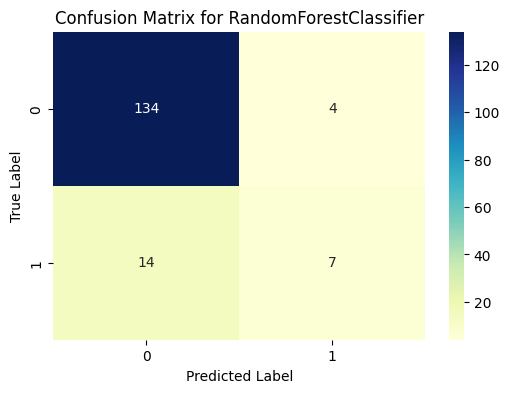

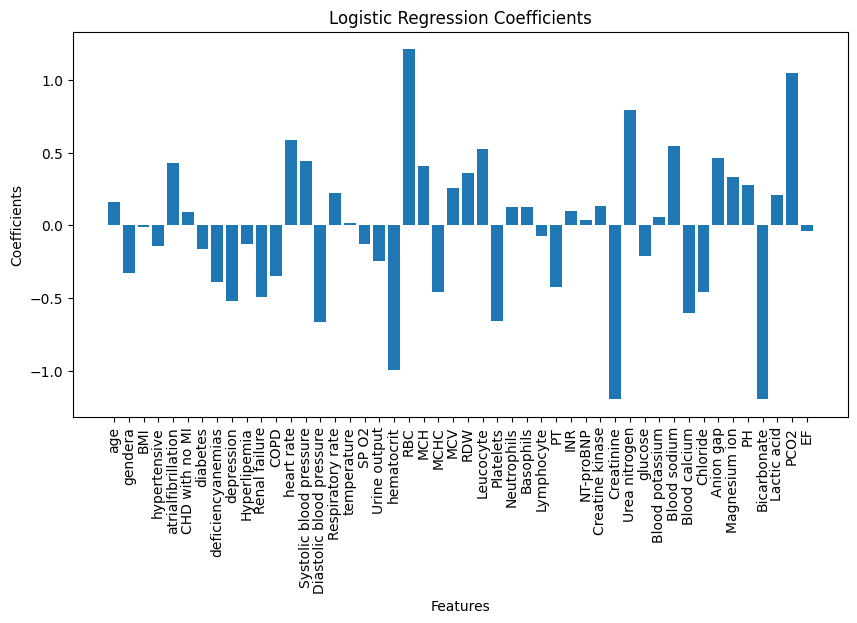

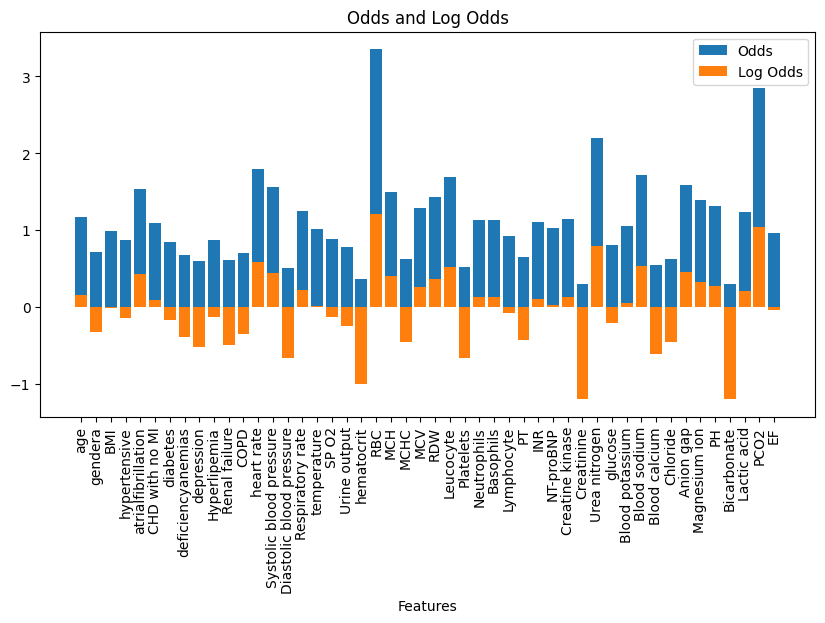

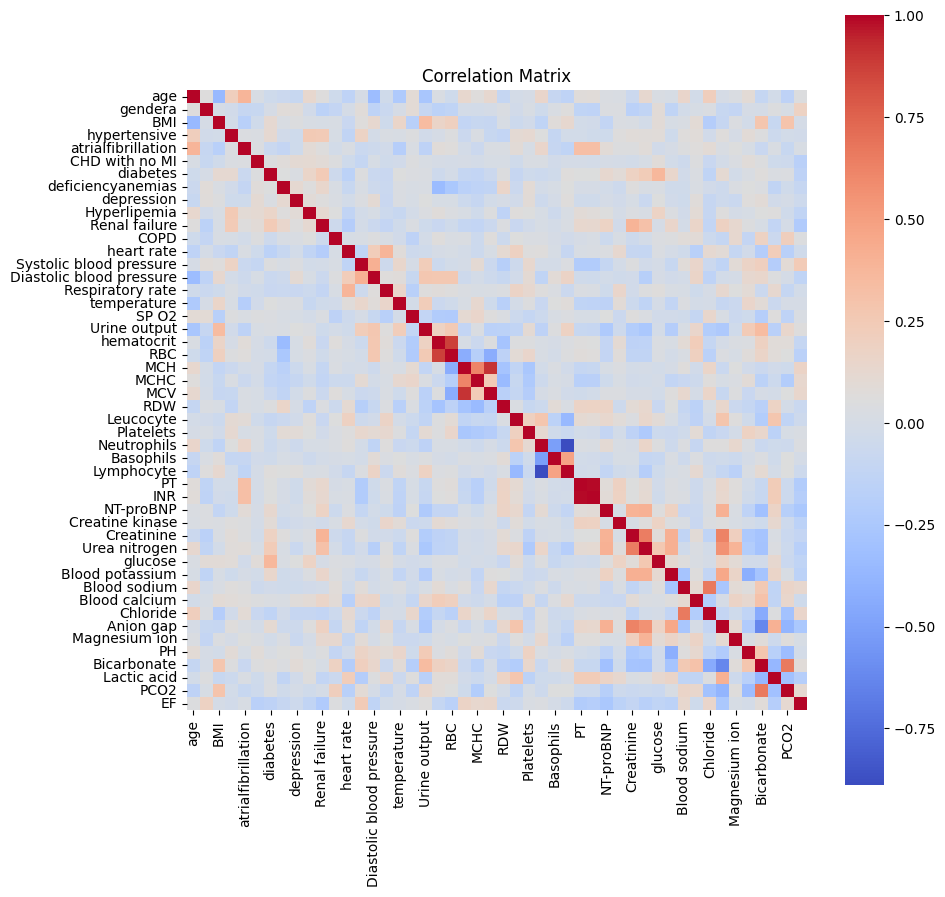

In [22]:
scores = evaluate(X_test, y_test, models)

# Plot confusion matrices
for i, model in enumerate(models):
    model_name = type(model.best_estimator_).__name__
    plot_confusion_matrix(scores['CMAT'][i], model_name)

# Plot coefficients, odds, and log odds for logistic regression
#lr_model = models[0].best_estimator_
lr_model = models['LogisticRegressionCV']
feature_names = X_train.columns
plot_coefficients(lr_model, feature_names)
plot_odds_log_odds(lr_model, feature_names)

# Plot correlation matrix
plot_correlation_matrix(X_train)


2. Support Vector Classifier

For non-linear SVC, it is not possible to obtain feature importance. Also, since we have 48 features, 2D/3D boundary plot for visulizing hyperplane margin optimizer is also impossible.

3. Gaussian Process Classifier

4. XGBoost Classifier

In [36]:
from sklearn import metrics
from xgboost import plot_tree
import matplotlib.pyplot as plt
xgb_model = models['XGBClassifier']
expected_y = y_test
predicted_y = xgb_model.predict(X_test)
print("Classification report:")
print(metrics.classification_report(expected_y, predicted_y))

print("Confusion matrix:")
print(metrics.confusion_matrix(expected_y, predicted_y))
plt.figure(figsize=(40, 40))
plot_tree(xgb_model, num_trees=0, rankdir='LR')

plt.savefig('xgboost_tree_plot.png', dpi=300, bbox_inches='tight')
plt.close()


Classification report:
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       138
         1.0       0.41      0.33      0.37        21

    accuracy                           0.85       159
   macro avg       0.66      0.63      0.64       159
weighted avg       0.84      0.85      0.84       159

Confusion matrix:
[[128  10]
 [ 14   7]]


<Figure size 4000x4000 with 0 Axes>

In [1]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 7.1 MB/s eta 0:00:00


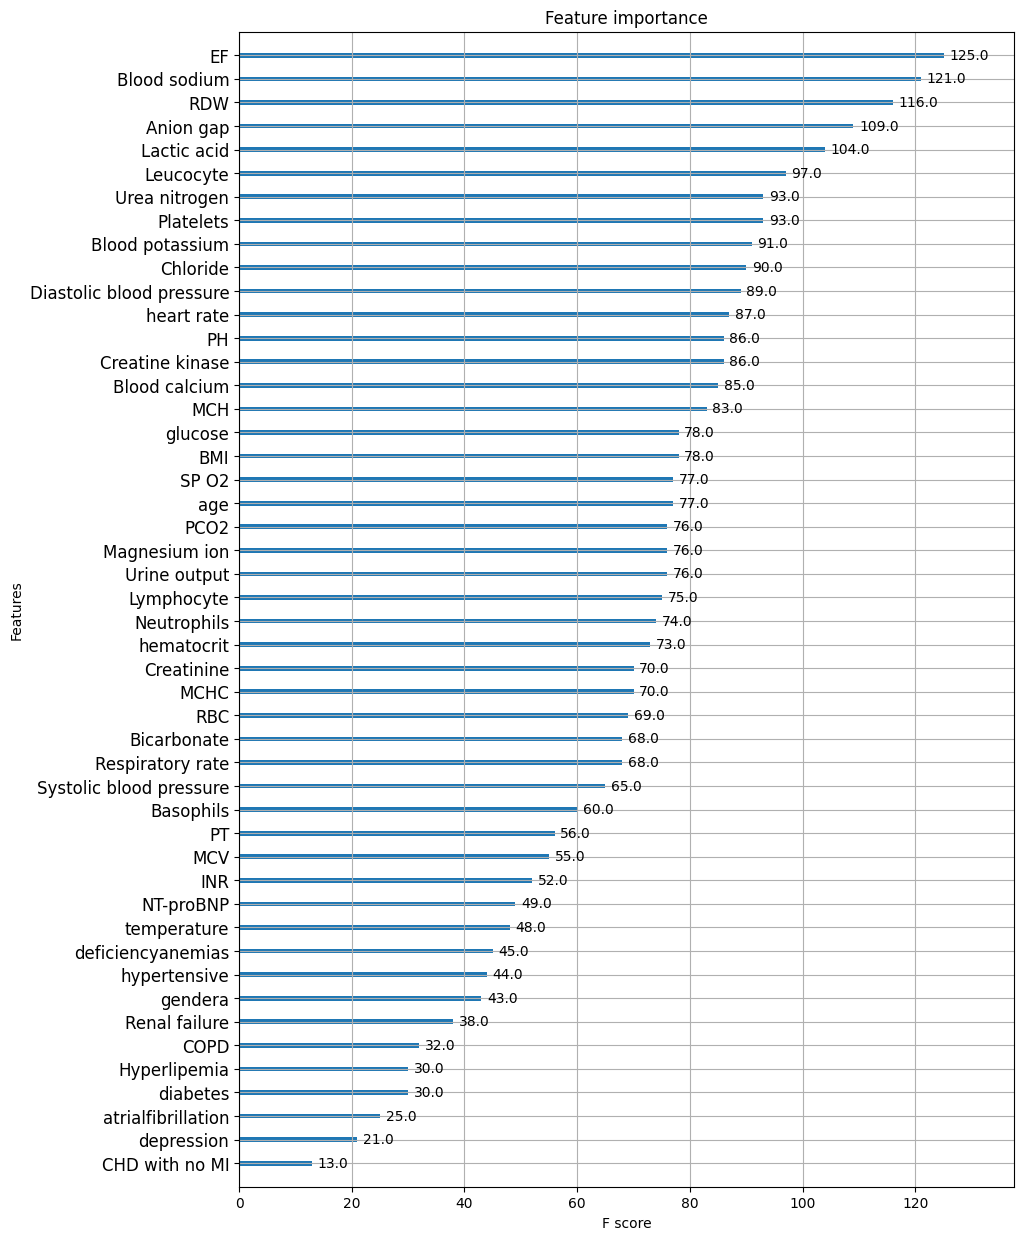

In [37]:
from xgboost import plot_importance
import shap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 15))  
plot_importance(xgb_model, ax=ax)
ax.tick_params(axis='y', labelsize=12) 
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


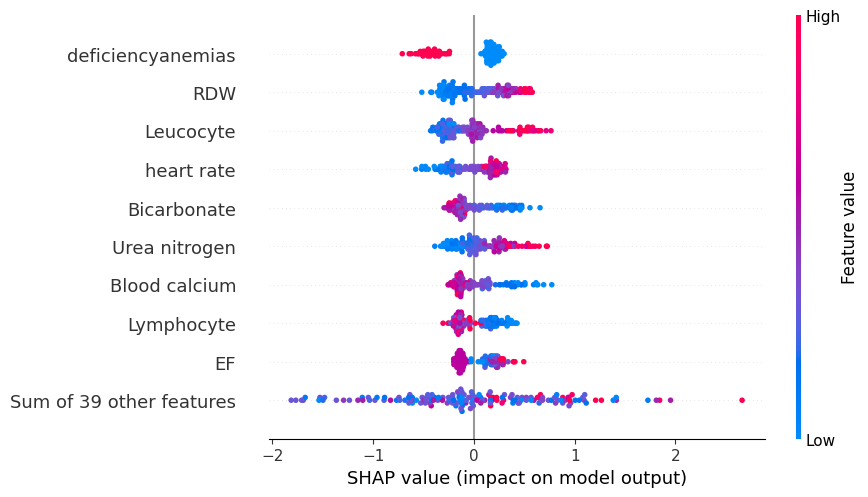

In [38]:
# Evaluate Shapley
explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

5. Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
#rf_model = models[4].best_estimator_
rf_model = models['RandomForestClassifier']
# Replace 'tree_index' with the index of the tree you want to plot
tree_index = 0

plt.figure(figsize=(40, 40))
plot_tree(rf_model.estimators_[tree_index], filled=True, feature_names=X_train.columns, rounded=True)

# Replace 'output_filename.png' with your desired file name and format (e.g., 'rf_tree_plot.jpg')
plt.savefig('rf_tree.png', dpi=300, bbox_inches='tight')
plt.close()



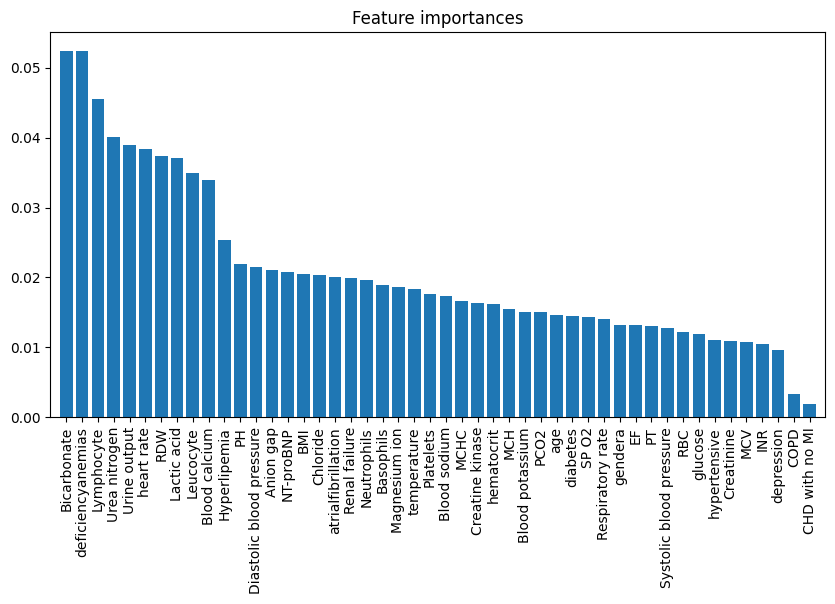

In [42]:
plt.show()
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [43]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=0c54bf6e2a572119bf297cc29f81070e7a3a6554bd57ffd6fb59a6e5a8b41eac
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [44]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns, 
                                                   class_names=['Survival', 'Dead'], # Replace with your actual class names
                                                   discretize_continuous=True)
instance_index = 1
instance = X_test.iloc[instance_index].values
exp = explainer.explain_instance(instance, rf_model.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
